In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from default_func import extract_image_file_name_from_lidar_file_name

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from os.path import join
import glob
import json

root_path_train = '.\\camera_lidar_semantic_bboxes\\train\\'
# get the list of files in lidar directory
file_names_lidar_train = sorted(glob.glob(join(root_path_train, '*\\lidar\\cam_front_center\\*.npz')))

root_path_test = '.\\camera_lidar_semantic_bboxes\\test\\'
# get the list of files in lidar directory
file_names_lidar_test = sorted(glob.glob(join(root_path_test, '*\\lidar\\cam_front_center\\*.npz')))

file_names_photo_train = []

for file_name_lidar in file_names_lidar_train:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_train, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_train.append(file_name_image)

file_names_photo_test = []

for file_name_lidar in file_names_lidar_test:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_test, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_test.append(file_name_image)

file_names_seg_maps_train = []

with open('preprocessed_masks/train_list.json', 'r') as f:
    preprocessed_train_masks = json.load(f)

with open('preprocessed_masks/test_list.json', 'r') as f:
    preprocessed_test_masks = json.load(f)

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

class UltraFastSegmentationDataset(Dataset):
    def __init__(self, image_files, preprocessed_mask_files, image_size=(300, 300)):
        self.image_files = image_files
        self.preprocessed_mask_files = preprocessed_mask_files
        self.image_size = image_size
        self.num_classes = 19

        # Transform для изображений (маски уже с resize)
        self.image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.image_files)
    
    def get_num_classes(self):
        return self.num_classes

    def __getitem__(self, idx):
        # Загружаем изображение
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("RGB")
        
        # Загружаем ПРЕДОБРАБОТАННУЮ маску (уже с resize)
        mask_path = self.preprocessed_mask_files[idx]
        mask_transformed = np.load(mask_path)
        
        # Преобразуем изображение
        img_transformed = self.image_transform(img)
        
        # Конвертируем маску в тензор
        mask_transformed = torch.from_numpy(mask_transformed).long()
        
        return img_transformed, mask_transformed
    
# Collate function для DataLoader
def collate_fn(batch):
    images = []
    masks = []
    
    for img, mask in batch:
        images.append(img)
        masks.append(mask)
    
    images = torch.stack(images, dim=0)
    masks = torch.stack(masks, dim=0)
    
    return images, masks

In [7]:
# 2. Создаем быстрые датасеты
train_dataset = UltraFastSegmentationDataset(
    file_names_photo_train, preprocessed_train_masks, (512, 512)
)
test_dataset = UltraFastSegmentationDataset(
    file_names_photo_test, preprocessed_test_masks, (512, 512)
)

# 3. Создаем DataLoader (теперь будет ОЧЕНЬ быстрый)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [8]:
import numpy as np

# Функция для визуализации батча
def visualize_batch(images, masks, num_samples=4):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 4))
    
    for i in range(num_samples):
        if i >= images.shape[0]:
            break
            
        # Денормализуем изображение
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        # Маска
        mask = masks[i].numpy()
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Image {i}')
        axes[i, 0].axis('off')
        
        im = axes[i, 1].imshow(mask, cmap='tab20', vmin=0, vmax=train_dataset.get_num_classes()-1)
        axes[i, 1].set_title(f'Mask {i}')
        axes[i, 1].axis('off')
        plt.colorbar(im, ax=axes[i, 1])
    
    plt.tight_layout()
    plt.show()

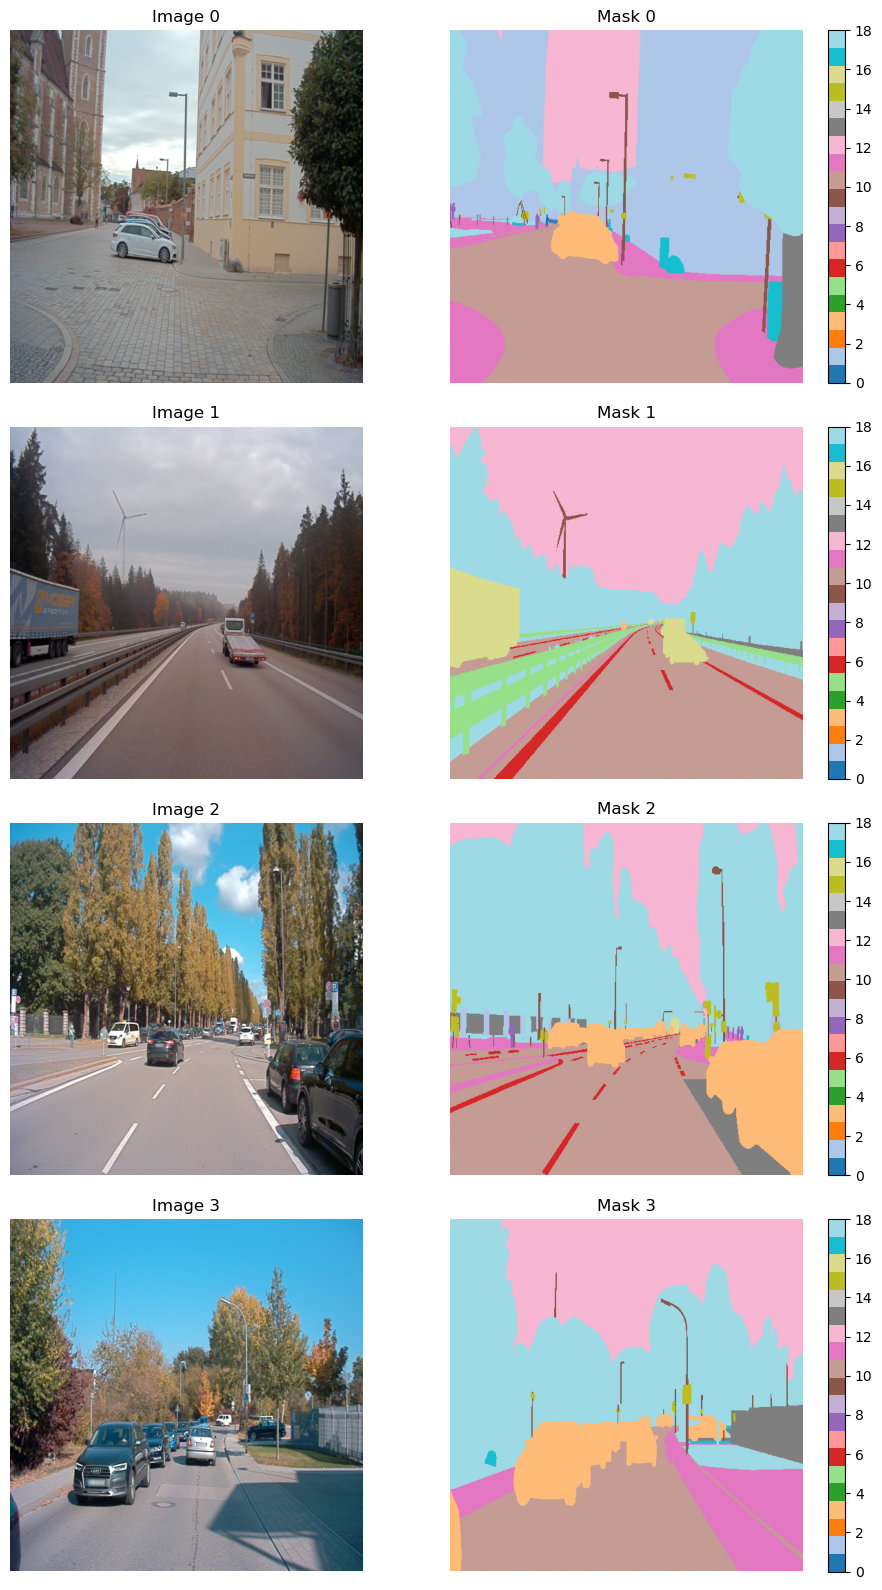

In [9]:
# Использование
for images, masks in train_loader:
    visualize_batch(images, masks)
    break

In [10]:
from torchvision.models.segmentation import deeplabv3_resnet50

def get_deeplabv3plus(num_classes, pretrained=True):
    model = deeplabv3_resnet50(pretrained=pretrained, pretrained_backbone=pretrained)
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    return model

In [11]:
# Гиперпараметры
num_classes = 19
learning_rate = 1e-4  # Уменьшили learning rate
weight_decay = 1e-4     # Weight decay для AdamW

In [12]:
# Инициализация модели
model = get_deeplabv3plus(num_classes, pretrained=True)
model = model.to(device)

c:\Users\neUral\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\neUral\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\neUral\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
c:\Users\neUral\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Argume

In [13]:
# Функция потерь и оптимизатор AdamW
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), 
                       lr=learning_rate, 
                       weight_decay=weight_decay)  # AdamW вместо Adam

# Scheduler для динамического изменения learning rate
scheduler = ReduceLROnPlateau(optimizer, 
                             mode='min',          # Минимизируем loss
                             factor=0.5,          # Умножаем LR на 0.5
                             patience=5,          # Ждем 5 эпох без улучшения
                             verbose=True,        # Выводим сообщения
                             min_lr=1e-7)         # Минимальный LR

c:\Users\neUral\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
checkpoint = torch.load('.\\models\\pitstop_deeplabv2_rn50.pth', map_location=device)
    
# Загружаем состояние модели
model.load_state_dict(checkpoint['model_state_dict'])

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# После загрузки оптимизатора
for param_group in optimizer.param_groups:
    param_group['lr'] = 3e-5  # Новое значение learning rate для fine-tuning

In [14]:
num_epochs = 40
history = []
history_test = []

In [15]:
from tqdm import tqdm

# Цикл обучения
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1} Train", leave=False):
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        main_output = outputs['out']
        aux_output = outputs['aux']
        
        # Вычисление потерь
        loss_main = criterion(main_output, masks)
        loss_aux = criterion(aux_output, masks)
        loss = loss_main + 0.4 * loss_aux
        
        # Backward pass и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Валидация
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc=f"Epoch {epoch+1} Test", leave=False):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            main_output = outputs['out']
            
            loss = criterion(main_output, masks)
            val_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    history.append(avg_train_loss)
    avg_val_loss = val_loss / len(test_loader)
    history_test.append(avg_val_loss)
    
    # Обновляем scheduler
    scheduler.step(avg_val_loss)
    
    # Текущий learning rate
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, '
          f'LR: {current_lr:.2e}')

Epoch [1/40], Train Loss: 0.4596, Val Loss: 0.1786, LR: 1.00e-04


Epoch [2/40], Train Loss: 0.2550, Val Loss: 0.1680, LR: 1.00e-04


Epoch [3/40], Train Loss: 0.2183, Val Loss: 0.1609, LR: 1.00e-04


Epoch [4/40], Train Loss: 0.1972, Val Loss: 0.1611, LR: 1.00e-04


Epoch [5/40], Train Loss: 0.1834, Val Loss: 0.1722, LR: 1.00e-04


Epoch [6/40], Train Loss: 0.1714, Val Loss: 0.1594, LR: 1.00e-04


Epoch [7/40], Train Loss: 0.1613, Val Loss: 0.1629, LR: 1.00e-04


Epoch [8/40], Train Loss: 0.1534, Val Loss: 0.1628, LR: 1.00e-04


Epoch [9/40], Train Loss: 0.1509, Val Loss: 0.1651, LR: 1.00e-04


Epoch [10/40], Train Loss: 0.1447, Val Loss: 0.1637, LR: 1.00e-04


Epoch [11/40], Train Loss: 0.1380, Val Loss: 0.1713, LR: 1.00e-04


Epoch [12/40], Train Loss: 0.1367, Val Loss: 0.1743, LR: 5.00e-05


Epoch [13/40], Train Loss: 0.1226, Val Loss: 0.1698, LR: 5.00e-05


Epoch [14/40], Train Loss: 0.1171, Val Loss: 0.1806, LR: 5.00e-05


Epoch [15/40], Train Loss: 0.1133, Val Loss: 0.1792, LR: 5.00e-05


Epoch [16/40], Train Loss: 0.1099, Val Loss: 0.1870, LR: 5.00e-05


Epoch [17/40], Train Loss: 0.1068, Val Loss: 0.1877, LR: 5.00e-05


Epoch [18/40], Train Loss: 0.1042, Val Loss: 0.1977, LR: 2.50e-05


Epoch [19/40], Train Loss: 0.0991, Val Loss: 0.2099, LR: 2.50e-05


Epoch [20/40], Train Loss: 0.0967, Val Loss: 0.2144, LR: 2.50e-05


KeyboardInterrupt: 

In [21]:
checkpoint = {
    'epoch': epoch,  # количество выполненных эпох
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_val_loss,  # значение функции потерь
    # можно добавлять и другие метрики, нужные для ваших экспериментов
}
torch.save(checkpoint, '.\\models\\pitstop_deeplabv2_rn50.pth')

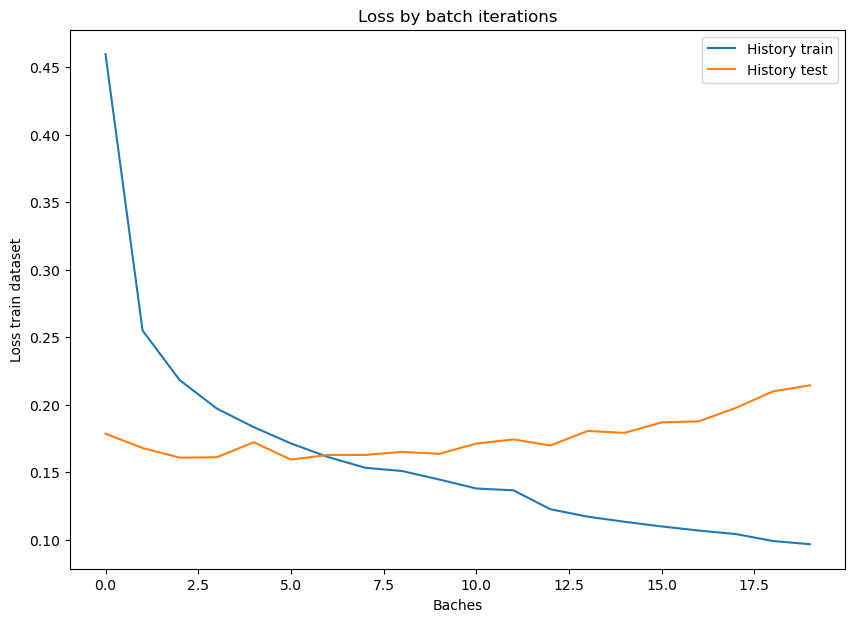

In [16]:
plt.figure(figsize=(10, 7))
plt.plot(history, label = 'History train')
plt.plot(history_test, label = 'History test')
plt.title('Loss by batch iterations')
plt.ylabel('Loss train dataset')
plt.xlabel('Baches')
#plt.yscale('log')
#plt.xscale('log')
plt.legend()

plt.show()

In [17]:
from os.path import join
import glob

root_path_train = '.\\camera_lidar_semantic_bboxes\\special\\'
# get the list of files in lidar directory
file_names_lidar_train = sorted(glob.glob(join(root_path_train, '*\\lidar\\cam_front_center\\*.npz')))

file_names_photo_train_vis = []

for file_name_lidar in file_names_lidar_train:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_train, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_train_vis.append(file_name_image)

start = 0
end = 0

for i in range(len(file_names_photo_train)):
    if file_names_photo_train[i][37:] == file_names_photo_train_vis[0][39:]:
        start = i
    if file_names_photo_train[i][37:] == file_names_photo_train_vis[-1][39:]:
        end = i

# 2. Создаем быстрые датасеты
special_dataset = UltraFastSegmentationDataset(
    file_names_photo_train_vis, preprocessed_train_masks[start:end], (512, 512)
)

# 3. Создаем DataLoader (теперь будет ОЧЕНЬ быстрый)
special_loader = DataLoader(special_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

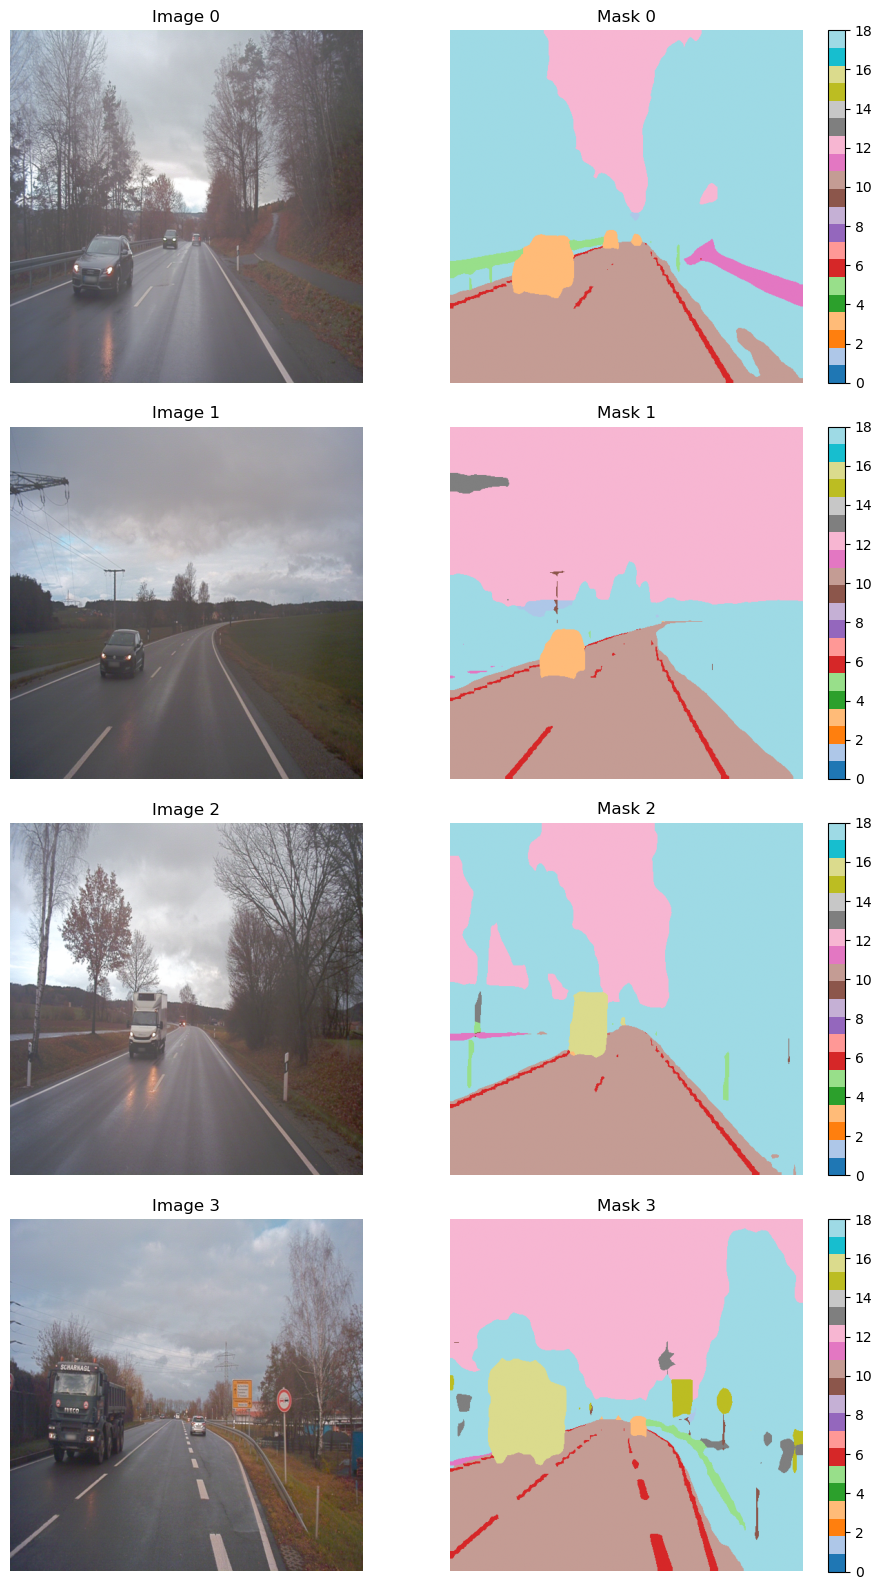

In [18]:
import torch.nn.functional as F

model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        main_output = outputs['out']

        predictions = torch.argmax(F.softmax(main_output, dim=1), dim=1)

        visualize_batch(images.cpu(), predictions.cpu())
        break

In [19]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

class SegmentationMetrics:
    def __init__(self, num_classes=19, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.num_classes = num_classes
        self.device = device
        
    def _get_confusion_matrix(self, pred, target):
        """Вычисляет матрицу confusion для батча"""
        pred = pred.flatten()
        target = target.flatten()
        mask = (target >= 0) & (target < self.num_classes)
        return confusion_matrix(
            target[mask].cpu().numpy(), 
            pred[mask].cpu().numpy(), 
            labels=list(range(self.num_classes))
        )
    
    def compute_iou(self, cm):
        """Вычисляет IoU из матрицы confusion"""
        intersection = np.diag(cm)
        union = cm.sum(axis=1) + cm.sum(axis=0) - intersection
        iou = intersection / (union + 1e-10)
        return iou
    
    def compute_precision_recall_f1(self, cm):
        """Вычисляет Precision, Recall и F1-score"""
        tp = np.diag(cm)
        fp = cm.sum(axis=0) - tp
        fn = cm.sum(axis=1) - tp
        
        precision = tp / (tp + fp + 1e-10)
        recall = tp / (tp + fn + 1e-10)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        
        return precision, recall, f1
    
    def compute_metrics(self, predictions, targets):
        """
        Вычисляет все метрики для батча предсказаний
        
        Args:
            predictions: torch.Tensor [batch_size, H, W] с предсказанными классами
            targets: torch.Tensor [batch_size, H, W] с истинными метками
        
        Returns:
            dict: Словарь со всеми вычисленными метриками
        """
        # Проверяем размерности
        assert predictions.shape == targets.shape, "Размеры predictions и targets должны совпадать"
        
        # Инициализируем общую матрицу confusion
        total_cm = np.zeros((self.num_classes, self.num_classes), dtype=np.int64)
        
        # Обрабатываем каждый элемент батча
        for i in range(predictions.shape[0]):
            pred = predictions[i]
            target = targets[i]
            cm = self._get_confusion_matrix(pred, target)
            total_cm += cm
        
        # Вычисляем все метрики
        iou_per_class = self.compute_iou(total_cm)
        precision_per_class, recall_per_class, f1_per_class = self.compute_precision_recall_f1(total_cm)
        
        # Вычисляем средние значения
        miou = np.nanmean(iou_per_class)
        mean_precision = np.nanmean(precision_per_class)
        mean_recall = np.nanmean(recall_per_class)
        mean_f1 = np.nanmean(f1_per_class)
        
        # Вычисляем Pixel Accuracy
        total_pixels = total_cm.sum()
        correct_pixels = np.diag(total_cm).sum()
        pixel_accuracy = correct_pixels / total_pixels
        
        # Mean Pixel Accuracy
        mean_pixel_accuracy = np.nanmean(np.diag(total_cm) / (total_cm.sum(axis=1) + 1e-10))
        
        return {
            'miou': miou,
            'iou_per_class': iou_per_class,
            'pixel_accuracy': pixel_accuracy,
            'mean_pixel_accuracy': mean_pixel_accuracy,
            'mean_precision': mean_precision,
            'mean_recall': mean_recall,
            'mean_f1': mean_f1,
            'precision_per_class': precision_per_class,
            'recall_per_class': recall_per_class,
            'f1_per_class': f1_per_class,
            'confusion_matrix': total_cm
        }

In [20]:
import torch.nn.functional as F

# Инициализация
metrics_calculator = SegmentationMetrics(num_classes=19)

# Предположим, у нас есть модель и данные
# model = YourSegmentationModel()
# dataloader = YourDataLoader()

all_metrics = []

for batch_idx, (images, targets) in enumerate(test_loader):
    with torch.no_grad():
        images = images.to(device)
        # Получаем предсказания (вероятности)
        outputs = model(images)
        main_output = outputs['out']

        predictions = torch.argmax(F.softmax(main_output, dim=1), dim=1)
        
        # Вычисляем метрики для батча
        metrics = metrics_calculator.compute_metrics(predictions.cpu(), targets)
        all_metrics.append(metrics)
        
        # Можно выводить промежуточные результаты
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}: mIoU = {metrics['miou']:.4f}, PA = {metrics['pixel_accuracy']:.4f}")

# Усредняем метрики по всем батчам
final_metrics = {
    'miou': np.mean([m['miou'] for m in all_metrics]),
    'pixel_accuracy': np.mean([m['pixel_accuracy'] for m in all_metrics]),
    'mean_pixel_accuracy': np.mean([m['mean_pixel_accuracy'] for m in all_metrics]),
    'mean_f1': np.mean([m['mean_f1'] for m in all_metrics])
}

print("\nFinal Metrics:")
print(f"Mean IoU: {final_metrics['miou']:.4f}")
print(f"Pixel Accuracy: {final_metrics['pixel_accuracy']:.4f}")
print(f"Mean Pixel Accuracy: {final_metrics['mean_pixel_accuracy']:.4f}")
print(f"Mean F1-Score: {final_metrics['mean_f1']:.4f}")

Batch 0: mIoU = 0.4147, PA = 0.9553
Batch 10: mIoU = 0.3997, PA = 0.9441
Batch 20: mIoU = 0.4585, PA = 0.9577
Batch 30: mIoU = 0.4306, PA = 0.9453
Batch 40: mIoU = 0.3611, PA = 0.9783
Batch 50: mIoU = 0.4576, PA = 0.9425
Batch 60: mIoU = 0.4372, PA = 0.9464

Final Metrics:
Mean IoU: 0.3948
Pixel Accuracy: 0.9534
Mean Pixel Accuracy: 0.4446
Mean F1-Score: 0.4486
